## A/B testing on an e-commerce website


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  
For this project, I ran an A/B test run by an e-commerce website. My goal is to to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. 


<a id='probability'></a>
#### Part I - Probability

In [56]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [57]:
df=pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [58]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [59]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [60]:
len(df[df['converted']==1])/len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [61]:
df[df['group']=='control']['landing_page'].value_counts()['new_page']+df[df['group']=='treatment']['landing_page'].value_counts()['old_page']

3893

f. Do any of the rows have missing values?

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


None of the rows have missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [63]:
indices_to_remove=df[(df['group'] == 'treatment') != (df['landing_page'] == 'new_page')].index.tolist()
indices_to_remove.append(df[(df['group'] == 'control') != (df['landing_page'] == 'old_page')].index.tolist())
desired_indices = [i for i in range(len(df)) if i not in indices_to_remove]
df2 = df.iloc[desired_indices]

In [64]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [65]:
df['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [66]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [67]:
df2.loc[2893,:]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [68]:
 df2.drop(index=2893,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [69]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [70]:
df2_control=df2.query('group=="control"')
df2_control['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [71]:
df2_treatment=df2.query('group=="treatment"')
df2_treatment['converted'].mean()

0.11880806551510564

In [72]:
obs_diff=df2_treatment['converted'].mean()-df2_control['converted'].mean()

d. What is the probability that an individual received the new page?

In [73]:
len(df2[df2['landing_page']=='new_page'])/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

There is a slight difference in the conversion rate between the new page and old page. We do not know, however, if this is purely based on chance. So, we have to statistically test this difference as below.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

Answer: 
We need to stop when there is strong (pre-determined) statistical power to test the difference. Statisical power is the probability of rejecting a false null hypothesis i.e. detecting an effect.

Statistical power depends on the size of an effect and sample size: larger effects are easier to detect and larger sample size (in this study, running for a longer time) has more sensitivity to detect smaller effects. So, a very large sample size can make a very small effect significant. So unless, we have a pre-determined sample size (i.e. how long to run the experiment) for a given statistical power, we cannot continue the experiment depending on what we see.  




These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null: P(converted_old_page)>=P(converted_new_page)

Alternative: P(converted_old_page)<P(converted_new_page)

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [74]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [75]:
p_old=p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [76]:
n_new=len(df2.query('group=="treatment"'))
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [77]:
n_old=len(df2.query('group=="control"'))
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [78]:
# results from n_new tests for one coin flip
new_page_converted=np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [79]:
# results from n_new tests for one coin flip
old_page_converted=np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [80]:
new_page_converted.mean()-old_page_converted.mean()

-0.00041519458056078762

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [81]:
p_diff=[]
for i in range(10000):
    # results from n_new tests for one coin flip
    new_page_converted=np.random.binomial(1, p_new, n_new)
    old_page_converted=np.random.binomial(1, p_old, n_old)
    p_diff.append(new_page_converted.mean()-old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.
Yes, it is a normal distribution. 

(array([  1.00000000e+00,   3.40000000e+01,   2.47000000e+02,
          1.09000000e+03,   2.48400000e+03,   3.07100000e+03,
          2.13400000e+03,   7.51000000e+02,   1.78000000e+02,
          1.00000000e+01]),
 array([-0.00517104, -0.0042061 , -0.00324116, -0.00227622, -0.00131127,
        -0.00034633,  0.00061861,  0.00158355,  0.00254849,  0.00351344,
         0.00447838]),
 <a list of 10 Patch objects>)

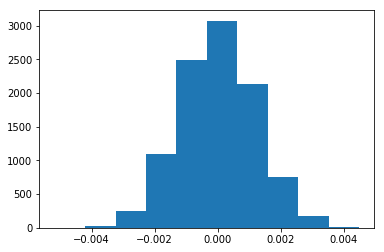

In [82]:
plt.hist(p_diff)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [83]:
(obs_diff<p_diff).mean()

0.90859999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This value is called p-value. This value means given the null hypothesis is true what is the proportion of values that is greater than the observed difference. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = len(df2_control.query('converted==1'))
convert_new = len(df2_treatment.query('converted==1'))
n_old = len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [85]:
data = pd.DataFrame({
    "Converted": [convert_new, convert_old],
    "Total": [n_new, n_old]
    }, index=['treatment', 'control'])

proportions_ztest(
    count=data.Converted, nobs=data.Total, alternative='larger'), 

((-1.3109241984234394, 0.90505831275902449),)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

P-value: The probability of observing the value or more extreme values given the null hypothesis is true.
Z-score: It is the number of standard deviations from the mean. It is a standard value that can be placed on a normal distribution allowing us to calculate the probability of score occurring within a normal distribution. 


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [86]:
df2[['ab_page', 'old_page',]] = pd.get_dummies(df2['landing_page'])
df2['intercept']=1

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [88]:
lm=sm.Logit(df2['converted'],df2[['ab_page','intercept']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:53:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

The model indicates there is a small, non-significant coefficient assoiciated with relating conversion rate to pages. The model predicts that subjects viewing the old page are 1.01 more likely to convert than the ones viewing the new page. 

In [89]:
# We need exp of coefficients to interprete the coefficients of logistic regression
1/np.exp(-0.015)

1.0151130646157189

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

Answer: In the case of regression, we test whether there is a signficant relationship between the new page being viewed and whether or not subjects convert. The null hypothesis is the coefficient being zero (suggesting no relationship) and the alternative is the coefficient being non-zero (suggesting a relationship). In the previous section, the hypotheses tested the difference between the proportion of conversions for the control and experiment groups. 


Another main differnce is the p-value obtained in the previous section corresponds to a one-tailed test while the test associated with the regression model is a two-tailed one. This is due to the fact that testing the coefficient in the regression model is testing whether or not the coefficient is zero (with equality sign) therefore a two-tailed test. In contrast, the z-test in part II is a one-tailed test because of its inequality sign in the hypotheses.   


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Answer: Considering other factors may lead to improvement of our prediction overall as other factors may contribute to whether or not subjects converted. 
The disadvantage is the issue of multicolinearity that the predictor variables are correlated with one another. This cause the coefficient being flipped from the direction we expect. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [90]:
df_country=pd.read_csv('countries.csv')
df_joined=df_country.set_index('user_id').join(df2.set_index('user_id'))

In [91]:
df_joined[['CA', 'UK','US',]]=pd.get_dummies(df_joined['country'])

In [92]:
lm=sm.Logit(df_joined['converted'],df_joined[['ab_page','CA','UK','intercept']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 09 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:53:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [93]:
df_joined['abpage_byCA']=df_joined['ab_page']*df_joined['CA']
df_joined['abpage_byUK']=df_joined['ab_page']*df_joined['UK']

lm=sm.Logit(df_joined['converted'],df_joined[['abpage_byCA','abpage_byUK','ab_page','CA','UK','intercept']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 09 Dec 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:53:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
abpage_byCA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
abpage_byUK     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page        -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA             -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK             -0.0057      0.019     -0.306      0.760      -0.043       0.031
intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
===============================================================================
"""

Niether the countries nor the interactions between countries and page turned out as signficant. 

**Conclusions**

From the testing the differnce between proportion of conversions between the experiment and the control group or testing the coefficient with the logistic regression, we found no significant relationship between the pages and converting. 

We conclude that the new page will not lead to more conversions compared to the older version. 

In [94]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0